# MSE and RSA

## Imports

In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
from IPython import display
import time
import pandas as pd
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
import seaborn as sns
from sklearn.decomposition import PCA
from make_models import get_MRI_CVAE_3D
from tqdm import tqdm
import tensorflow as tf
from rsa_funcs import fit_rsa,make_RDM,get_triu

/data/bergerar/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.2)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
pwd

'/mmfs1/data/bergerar/BC-MRI-ADHD/Code'

## Load and Sort Data

In [3]:
stuff = np.load('../Assets/brain_array-440.npz')
print(list(stuff.keys()))

data = stuff['data']
control = stuff['controls']
patients = stuff['patients']
n = data.shape[0]
#print(data.shape)
#data[patients,:,:,:].shape
#data[patients].shape

data_patients = data[patients,:,:,:]
data_controls = data[control,:,:,:]

print(data_patients.shape)
print(data_controls.shape)

['data', 'controls', 'patients']
(179, 64, 64, 64)
(261, 64, 64, 64)


## CVAE

In [4]:
cvae, z_encoder, s_encoder, cvae_decoder = get_MRI_CVAE_3D(input_shape=(64,64,64,1),
                    latent_dim=2,
                    beta=1,
                    disentangle=False,
                    gamma=1,
                    bias=True,
                    batch_size = 64,
                    kernel_size = 3,
                    filters = 32,
                    intermediate_dim = 128,
                    opt=None)

## Load Weights

In [5]:
cvae.load_weights('../Assets/tf_weights_10000_AB/tf_weightsAB')

In [6]:
data_patients.shape

(179, 64, 64, 64)

## Get Reconstructions

In [7]:
def get_reconstruction(data_in,adhd = True):

    z = z_encoder.predict(data_in)[0] # mu,std,sample
    s = s_encoder.predict(data_in)[0]

    if adhd==True:
        l = np.hstack((z,s))
    else:
        l = np.hstack((z,np.zeros(s.shape)))

    recon = cvae_decoder(l)[:,:,:,:,0]
    return recon

In [8]:
%%time
recon_patients = get_reconstruction(data_patients,adhd = True)
recon_controls = get_reconstruction(data_controls,adhd = False)


CPU times: user 2min 3s, sys: 16.6 s, total: 2min 20s
Wall time: 1min 2s


In [9]:
recon_patients.shape

TensorShape([179, 64, 64, 64])

In [10]:
np.array(recon_patients).max()

0.8697046

In [11]:
np.array(recon_patients).min()

0.008435845

In [12]:
np.array(data_patients).max()


1.0

In [13]:
np.array(data_patients).min()


0.0

## Reconstruction: Subject 0

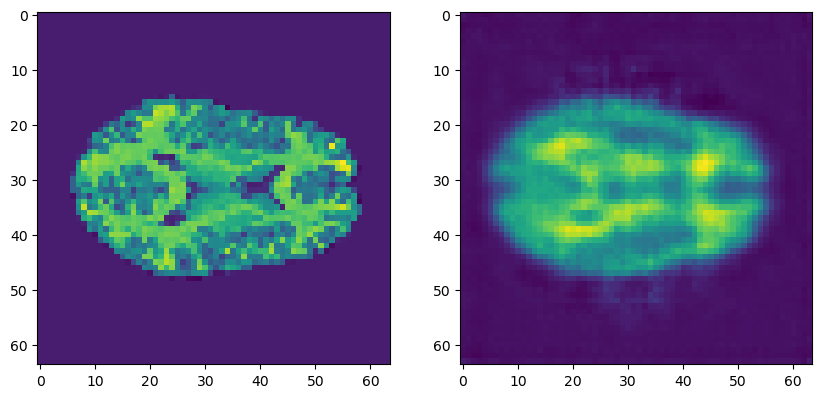

In [14]:
s = 0
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(data_patients[s,:,:,32])
plt.subplot(1,2,2)
plt.imshow(recon_patients[s,:,:,32])
plt.show()

## MSE: Subject 0

In [15]:
data = data_patients[0,:,:,:]
predict = recon_patients[0,:,:,:]
# Using 'auto'/'sum_over_batch_size' reduction type.
mse = tf.keras.losses.MeanSquaredError()
mse(data, predict).numpy()

0.001449396

In [16]:
data = np.array(data_patients[0,:,:,:])
predict = np.array(recon_patients[0,:,:,:])
mse = ((data-predict)**2).mean()

## Reconstruction: Subject 1

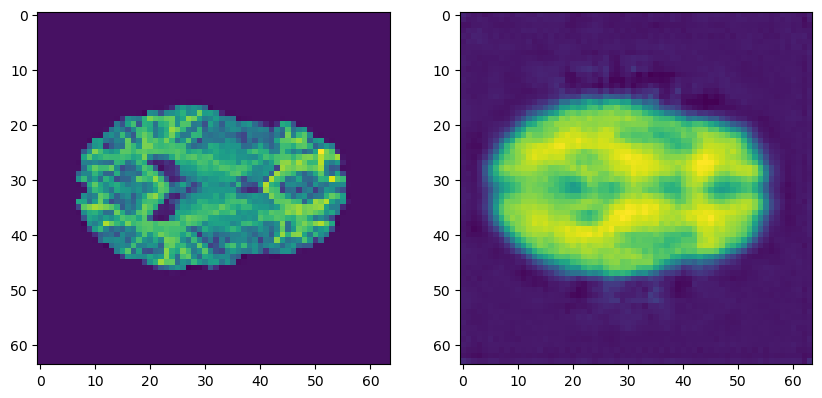

In [17]:
s = 1
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(data_patients[s,:,:,32])
plt.subplot(1,2,2)
plt.imshow(recon_patients[s,:,:,32])
plt.show()

## Reconstruction: Subject 2

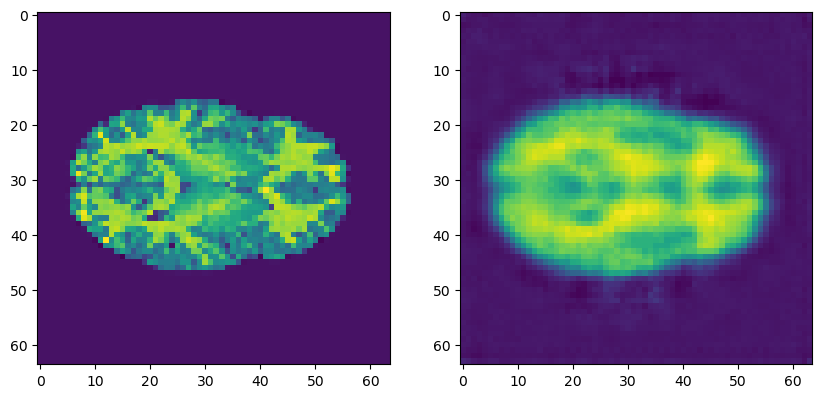

In [18]:
s = 2
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(data_patients[s,:,:,32])
plt.subplot(1,2,2)
plt.imshow(recon_patients[s,:,:,32])
plt.show()

## MSE loop

In [19]:
mse_list = []
for s in range(0,179):
    data = np.array(data_patients[s,:,:,:])
    predict = np.array(recon_patients[s,:,:,:])
    mse = ((data-predict)**2).mean()
    mse_list.append(mse)

mse_arr = np.array(mse_list)

## Mean Squared Error

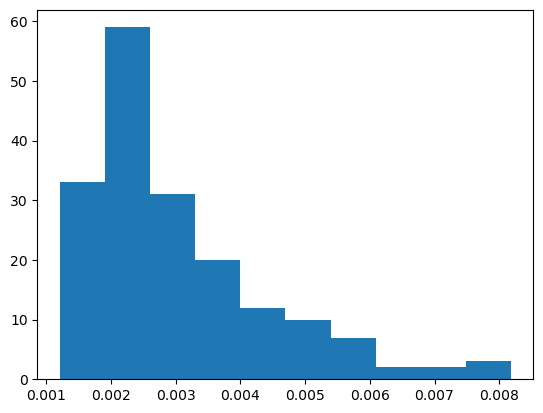

In [20]:
plt.hist(mse_arr)
plt.show()

In [21]:
np.argmin(mse_arr) #

5

## Best Reconstruction

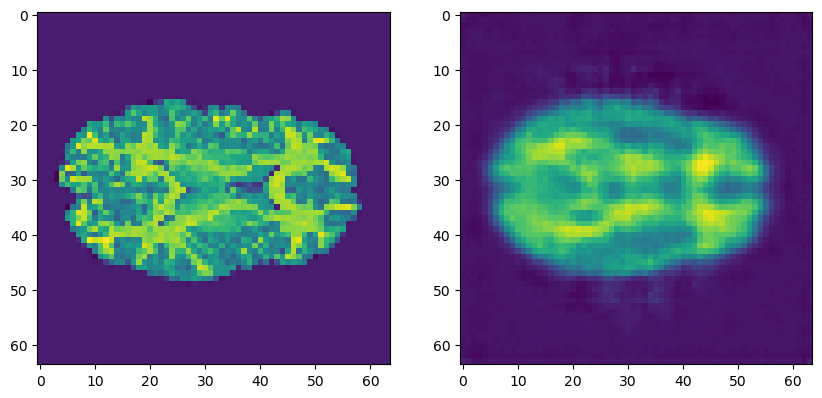

In [22]:
s = 5
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(data_patients[s,:,:,32])
plt.subplot(1,2,2)
plt.imshow(recon_patients[s,:,:,32])
plt.show()

In [23]:
np.argmax(mse_arr) #

154

## Worst Reconstruction

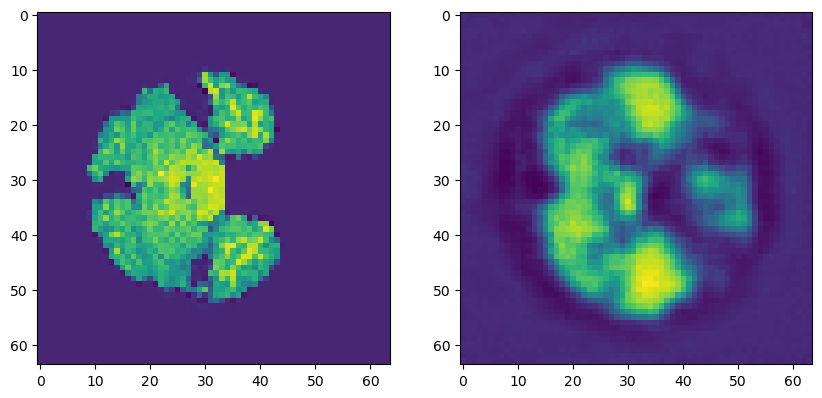

In [24]:
s = 154
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(data_patients[s,:,:,32])
plt.subplot(1,2,2)
plt.imshow(recon_patients[s,:,:,32])
plt.show()

## Read DF

In [25]:
df = pd.read_csv('../Data/df_440.csv')

## Make ADHD Dataframe

In [26]:
ADHDdf = df[df['DX'] != 0]
TDdf = df[df['DX'] == 0]
ADHD_index_df = ADHDdf[ADHDdf['ADHD Index']!= -999]

In [27]:
#ADHDdf.to_csv('../Data/ADHDdf_179.csv')

In [28]:
ADHDdf

Unnamed: 0  Unnamed: 0.1  Unnamed: 0.1.1  Subject  ScanDir ID  Site  \
1            27            27              27       27   2026113.0     3   
4            30            30              30       30   1623716.0     3   
7            33            33              33       33   3154996.0     3   
8            34            34              34       34   3160561.0     3   
9            35            35              35       35   4275075.0     3   
..          ...           ...             ...      ...         ...   ...   
381         572           572             572      572   2367157.0     1   
383         577           577             577      577   2697768.0     1   
386         581           581             581      581   2897046.0     1   
393         602           602             602      602   3976121.0     1   
394         609           609             609      609   4334113.0     1   

     Gender    Age  Handedness  DX  ... Med Status  QC_Rest_1  QC_Rest_2  \
1       0.0  12.99         1.0   1  ...        1.0        1.0        NaN   
4       0.0  12.65         1.0   1  ...        1.0        1.0        NaN   
7       1.0  11.65         1.0   3  ...        1.0        1.0        NaN   
8       1.0  11.95         1.0   1  ...        1.0        1.0        NaN   
9       0.0  10.50         1.0   3  ...        1.0        1.0        NaN   
..      ...    ...         ...  ..  ...        ...        ...        ...   
381     1.0  12.08         1.0   1  ...        2.0     -999.0        NaN   
383     0.0  12.58         1.0   3  ...        1.0        1.0        NaN   
386     0.0   9.17         1.0   3  ...        1.0        1.0        NaN   
393     1.0  11.00         1.0   1  ...        1.0        1.0        NaN   
394     1.0  14.58         1.0   3  ...        2.0     -999.0        NaN   

     QC_Rest_3  QC_Rest_4  QC_Anatomical_1  QC_Anatomical_2  ID        subID  \
1          NaN        NaN              1.0              NaN NaN  sub-2026113   
4          NaN        NaN              1.0              NaN NaN  sub-1623716   
7          NaN        NaN              1.0              NaN NaN  sub-3154996   
8          NaN        NaN              1.0              NaN NaN  sub-3160561   
9          NaN        NaN              1.0              NaN NaN  sub-4275075   
..         ...        ...              ...              ...  ..          ...   
381        NaN        NaN           -999.0              NaN NaN  sub-2367157   
383        NaN        NaN              1.0              NaN NaN  sub-2697768   
386        NaN        NaN              1.0              NaN NaN  sub-2897046   
393        NaN        NaN              1.0              NaN NaN  sub-3976121   
394        NaN        NaN           -999.0              NaN NaN  sub-4334113   

     has_brain  
1         True  
4         True  
7         True  
8         True  
9         True  
..         ...  
381       True  
383       True  
386       True  
393       True  
394       True  

[179 rows x 30 columns]

## Notes on booleans

In [29]:
np.array(True) + np.array(False)
np.array(False) + np.array(False)
np.array(True) * np.array(False)
np.array(False) * np.array(False)
# for booleans + means or , * means and

False

In [30]:
~np.array(True)

False

## RDMS: ADHD Index

In [31]:
symptom_vector = ADHDdf['ADHD Index'].values
symptom_vector

array([  90.,   87.,   64.,   71.,   87.,   90.,   62.,   60.,   77.,
         64.,   67.,   69.,   71.,   84.,   62.,   77.,   71.,   62.,
         79.,   67.,   79.,   78.,   60.,   77.,   86.,   64.,   62.,
         64.,   63.,   77.,   71.,   76.,   84.,   60.,   69.,   74.,
         55.,   63.,   75.,   72.,   56.,   77.,   65.,   82.,   75.,
         69.,   76.,   83.,   73.,   71.,   58.,   90.,   72.,   79.,
         66.,   75.,   64.,   63.,   86.,   74.,   82.,   74.,   63.,
         73.,   65.,   60.,   72.,   76.,   62.,   90.,   68.,   84.,
         67.,   76.,   76.,   62.,   90.,   63.,   82.,   70.,   80.,
         78.,   69.,   75.,   80.,   71.,   68.,   65., -999.,   71.,
         55., -999.,   72.,   76.,   65.,   79.,   70.,   81.,   81.,
         58.,   68.,   76.,   67.,   77.,   77.,   69.,   70.,   79.,
         68.,   66.,   90.,   59.,   58.,   63.,   61.,   65.,   68.,
         65.,   60.,   63.,   71.,   99.,   73.,   84.,   71.,   73.,
         77.,   77.,

In [32]:
is_999 = symptom_vector==-999

In [33]:
is_nan = np.isnan(symptom_vector)

In [34]:
is_nan

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [35]:
is_not_nan = ~is_nan
is_not_nan

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [36]:
is_not_999 = ~is_999
is_not_999

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [37]:
good_subjects = is_not_999 * is_not_nan
good_subjects

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [38]:
symptom_good_patients = symptom_vector[good_subjects]

In [39]:
s_patients = s_encoder.predict(data_patients)[0]
z_patients = z_encoder.predict(data_patients)[0]
symptom = np.array(symptom_good_patients)

In [40]:
z_good_patients = z_patients[good_subjects,:]

In [41]:
s_good_patients = s_patients[good_subjects,:]

In [42]:
s_patients_rdm = make_RDM(s_good_patients)
z_patients_rdm = make_RDM(z_good_patients)
symptom_rdm = make_RDM(symptom_good_patients)

In [43]:
symptom_rdm.shape

(147, 147)

In [44]:
z_patients_rdm.shape

(147, 147)

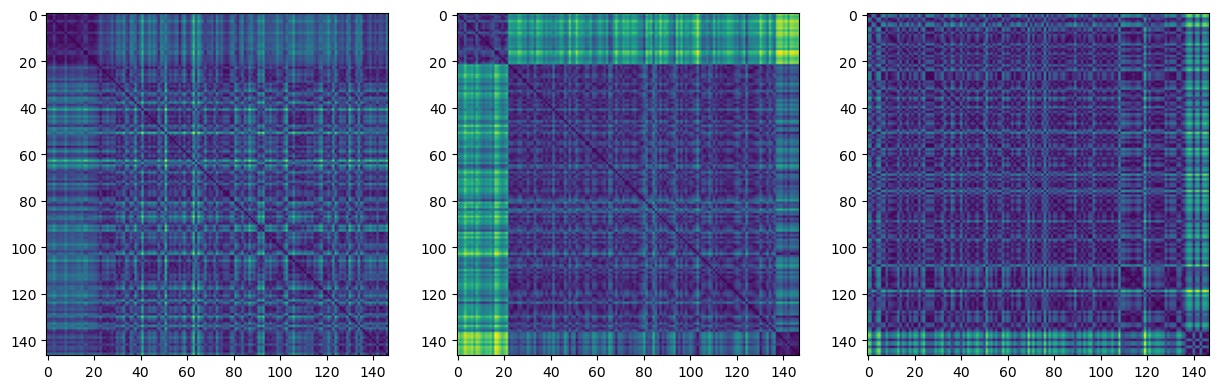

In [45]:
plt.figure(figsize = (15,5))
plt.subplot(1,3,1)
plt.imshow(s_patients_rdm)
plt.subplot(1,3,2)
plt.imshow(z_patients_rdm)
plt.subplot(1,3,3)
plt.imshow(symptom_rdm)
plt.show()

## RSA: ADHD Index

In [46]:
fit_rsa(s_patients_rdm, symptom_rdm)

-0.040834935303027814

In [47]:
fit_rsa(z_patients_rdm, symptom_rdm)

0.1374818335769203

## RDMS: Inattentive Index

In [48]:
inattentive_vector = ADHDdf['Inattentive'].values
inattentive_vector

array([  89.,   90.,   74.,   62.,   75.,   90.,   65.,   65.,   76.,
         61.,   64.,   67.,   60.,   88.,   60.,   80.,   74.,   64.,
         90.,   73.,   75.,   73.,   56.,   81.,   82.,   52.,   66.,
         69.,   63.,   76.,   74.,   77.,   80.,   61.,   64.,   68.,
         51.,   61.,   74.,   71.,   62.,   80.,   64.,   80.,   70.,
         73.,   78.,   90.,   73.,   76.,   65.,   90.,   72.,   83.,
         80.,   68.,   65.,   61.,   84.,   80.,   79.,   73.,   61.,
         68.,   76.,   64.,   60.,   73.,   55.,   90.,   64.,   84.,
         67.,   69.,   76.,   64.,   90.,   59.,   67.,   74.,   76.,
         73.,   67.,   75.,   77.,   79.,   67.,   59., -999.,   69.,
         57., -999.,   81.,   79.,   68.,   79.,   72.,   81.,   79.,
         51.,   66.,   78.,   73.,   72.,   73.,   69.,   73.,   81.,
         69.,   65.,   90.,   64.,   58.,   58.,   59.,   66.,   56.,
         63.,   56.,   61.,   73.,   77.,   72.,   86.,   69.,   60.,
         79.,   74.,

In [49]:
inattentive_is_999 = inattentive_vector==-999

In [50]:
inattentive_is_nan = np.isnan(inattentive_vector)

In [51]:
inattentive_is_nan

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [52]:
inattentive_is_not_nan = ~inattentive_is_nan
inattentive_is_not_nan

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [53]:
inattentive_is_not_999 = ~inattentive_is_999
inattentive_is_not_999

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [54]:
inattentive_good_subjects = inattentive_is_not_999 * inattentive_is_not_nan
inattentive_good_subjects

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [55]:
inattentive_good_patients = inattentive_vector[inattentive_good_subjects]

In [56]:
z_good_patients_inattentive = z_patients[inattentive_good_subjects,:]
s_good_patients_inattentive = s_patients[inattentive_good_subjects,:]

In [57]:
s_patients_rdm_inattentive = make_RDM(s_good_patients_inattentive)
z_patients_rdm_inattentive = make_RDM(z_good_patients_inattentive)
inattentive_rdm = make_RDM(inattentive_good_patients)

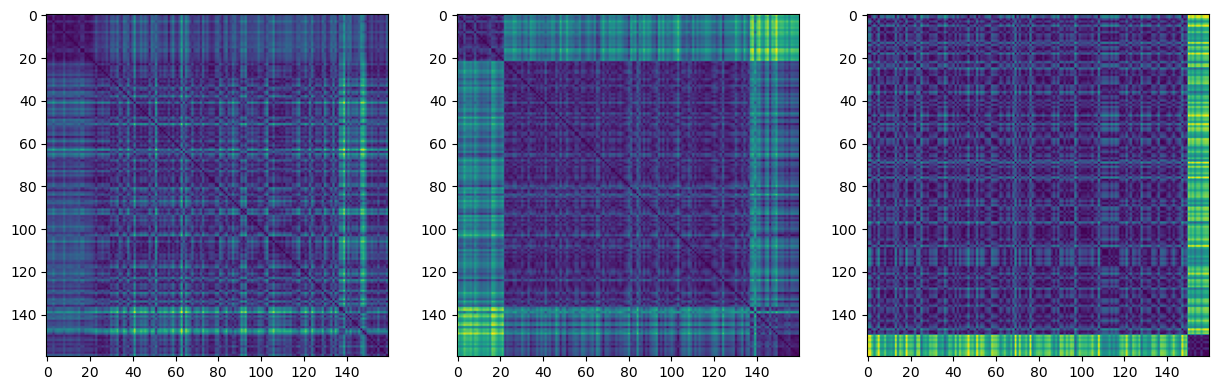

In [58]:
plt.figure(figsize = (15,5))
plt.subplot(1,3,1)
plt.imshow(s_patients_rdm_inattentive)
plt.subplot(1,3,2)
plt.imshow(z_patients_rdm_inattentive)
plt.subplot(1,3,3)
plt.imshow(inattentive_rdm)
plt.show()

## RSA: Inattentive Index

In [59]:
fit_rsa(s_patients_rdm_inattentive, inattentive_rdm)

-0.05433071306678199

In [60]:
fit_rsa(z_patients_rdm_inattentive, inattentive_rdm)

0.08881838782506726

## RDMS: Hyperactive/Impulsive Index

In [61]:
HI_vector = ADHDdf['Hyper/Impulsive'].values
HI_vector

array([  78.,   90.,   58.,   70.,   69.,   90.,   61.,   66.,   66.,
         68.,   60.,   76.,   66.,   75.,   61.,   83.,   82.,   56.,
         83.,   69.,   83.,   89.,   48.,   80.,   85.,   70.,   43.,
         65.,   52.,   87.,   62.,   68.,   67.,   66.,   65.,   82.,
         63.,   59.,   72.,   79.,   52.,   70.,   68.,   79.,   66.,
         74.,   72.,   65.,   58.,   50.,   56.,   80.,   72.,   76.,
         69.,   63.,   60.,   54.,   73.,   63.,   90.,   71.,   66.,
         81.,   52.,   58.,   86.,   74.,   54.,   90.,   71.,   86.,
         79.,   83.,   87.,   46.,   80.,   70.,   74.,   66.,   77.,
         79.,   70.,   72.,   78.,   54.,   78.,   56., -999.,   75.,
         47., -999.,   61.,   67.,   66.,   68.,   62.,   90.,   63.,
         74.,   52.,   61.,   54.,   87.,   74.,   86.,   57.,   79.,
         55.,   62.,   80.,   49.,   48.,   54.,   68.,   77.,   76.,
         80.,   66.,   66.,   47.,   90.,   71.,   56.,   76.,   68.,
         66.,   78.,

In [62]:
HI_is_999 = HI_vector==-999

In [63]:
HI_is_nan = np.isnan(HI_vector)

In [64]:
HI_is_nan

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [65]:
HI_is_not_nan = ~HI_is_nan
HI_is_not_nan

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [66]:
HI_is_not_999 = ~HI_is_999
HI_is_not_999

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [67]:
HI_good_subjects = HI_is_not_999 * HI_is_not_nan
HI_good_subjects

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [68]:
HI_good_patients = HI_vector[HI_good_subjects]

In [69]:
s_patients = s_encoder.predict(data_patients)[0]
z_patients = z_encoder.predict(data_patients)[0]
HI = np.array(HI_good_patients)

In [70]:
z_good_patients_HI = z_patients[HI_good_subjects,:]

In [71]:
s_good_patients_HI = s_patients[HI_good_subjects,:]

In [72]:
s_patients_rdm_HI = make_RDM(s_good_patients_HI)
z_patients_rdm_HI = make_RDM(z_good_patients_HI)
HI_rdm = make_RDM(HI_good_patients)

In [73]:
s_patients_rdm_HI.shape

(160, 160)

In [74]:
z_patients_rdm_HI.shape

(160, 160)

In [75]:
HI_rdm.shape

(160, 160)

## RSA: Hyperactive/Impulsive Index

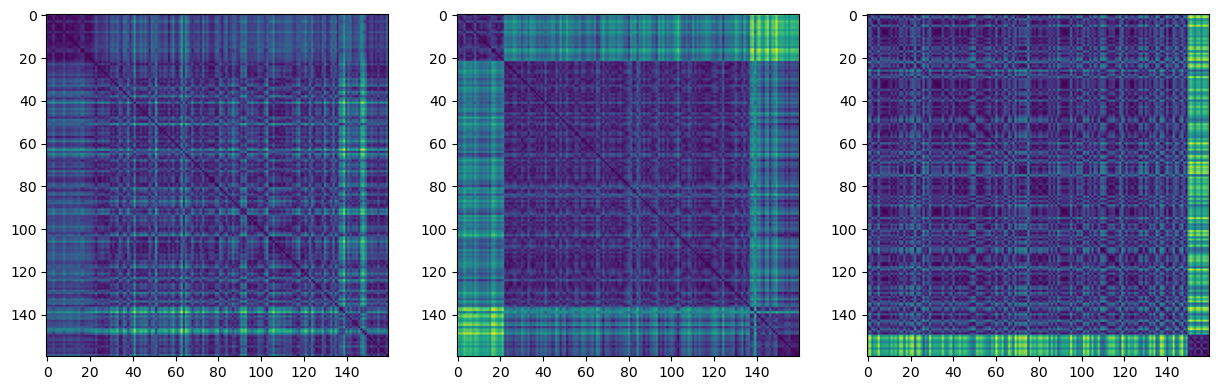

In [76]:
plt.figure(figsize = (15,5))
plt.subplot(1,3,1)
plt.imshow(s_patients_rdm_HI)
plt.subplot(1,3,2)
plt.imshow(z_patients_rdm_HI)
plt.subplot(1,3,3)
plt.imshow(HI_rdm)
plt.show()

## RSA: Hyperactive/Impulsive Index

In [77]:
fit_rsa(s_patients_rdm_HI, HI_rdm)

-0.05541938565814727

In [78]:
fit_rsa(z_patients_rdm_HI, HI_rdm)

0.09133735118152105

## RDMS: Age

In [79]:
age_vector = ADHDdf['Age'].values
age_vector

array([12.99, 12.65, 11.65, 11.95, 10.5 , 10.36,  8.72, 10.35, 11.04,
        9.97, 10.15, 11.89, 12.98,  8.1 ,  8.19,  8.99,  8.8 ,  9.08,
        8.45,  9.52,  9.43,  9.06,  8.29,  8.78,  8.04, 12.79,  9.57,
        8.61, 13.32,  8.56, 10.12, 10.06, 10.26, 11.18,  7.55,  7.26,
       13.56,  8.11, 10.41,  9.17, 12.07, 11.06, 11.53, 11.61, 13.49,
       10.78,  8.53,  8.38, 10.69,  9.17, 11.28, 12.28, 12.62,  8.49,
        8.61, 10.21, 10.36,  9.26,  7.86,  8.05,  9.24,  7.49,  9.38,
       11.97, 11.8 ,  9.32, 10.81,  9.23, 13.28, 10.16,  7.24, 11.33,
        9.92, 10.7 , 10.92,  9.98, 11.17, 11.92, 12.41, 11.54,  8.37,
       12.12,  9.42, 12.41, 11.1 ,  8.95, 10.9 , 10.65,  9.81, 17.43,
       15.4 , 15.63, 14.95,  8.75, 12.72, 11.41, 16.14, 15.9 ,  7.77,
       16.08, 17.37, 14.81,  8.19, 16.32,  8.93, 14.39, 14.94, 14.2 ,
       17.15, 13.24,  9.16, 15.32, 11.21, 11.82, 16.77, 13.33, 11.73,
        8.06, 11.09,  9.59, 15.81, 11.37, 15.83, 17.61,  8.75, 13.09,
       12.38,  7.35,

In [80]:
s_patients = s_encoder.predict(data_patients)[0]
z_patients = z_encoder.predict(data_patients)[0]
#age_vector

In [81]:
s_patients.shape

(179, 2)

In [82]:
z_patients.shape

(179, 2)

In [83]:
age_vector.shape

(179,)

In [84]:
s_patients_rdm_age = make_RDM(s_patients)
z_patients_rdm_age = make_RDM(z_patients)
age_rdm = make_RDM(age_vector)

In [85]:
s_patients_rdm_age.shape

(179, 179)

In [86]:
z_patients_rdm_age.shape

(179, 179)

In [87]:
age_rdm.shape

(179, 179)

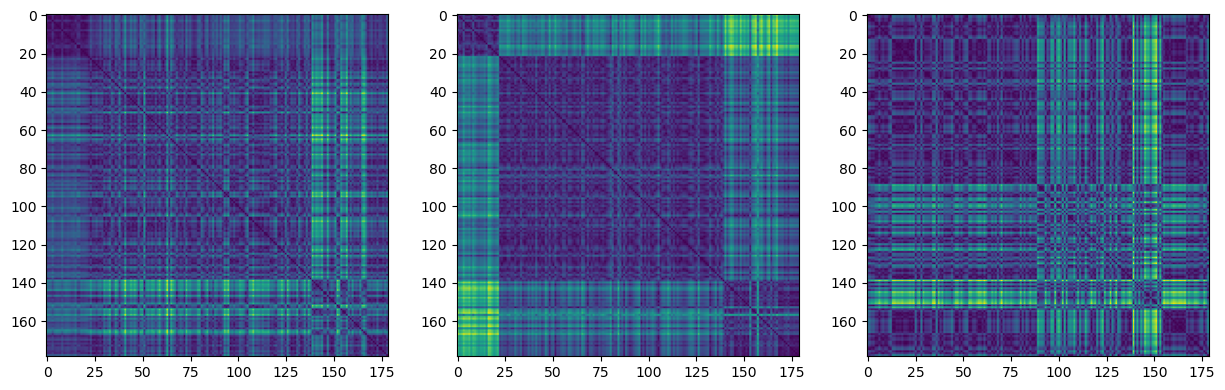

In [88]:
plt.figure(figsize = (15,5))
plt.subplot(1,3,1)
plt.imshow(s_patients_rdm_age)
plt.subplot(1,3,2)
plt.imshow(z_patients_rdm_age)
plt.subplot(1,3,3)
plt.imshow(age_rdm)
plt.show()

## RSA: Age

In [89]:
fit_rsa(s_patients_rdm_age, age_rdm)

0.10660751635312748

In [90]:
fit_rsa(z_patients_rdm_age, age_rdm)

-0.05047066482270839

## RDMS: Gender

In [91]:
gender_vector = ADHDdf['Gender'].values
gender_vector

array([ 0.,  0.,  1.,  1.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,
        0.,  1.,  0.,  1.,  1.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,  1.,
        0.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  0.,  1.,  0.,
        1.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,
        1.,  0.,  1.,  1.,  0.,  1.,  0.,  1.,  1.,  1.,  1.,  0.,  1.,
        0.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1., nan,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  0.,  0.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  0.,  1.,  0.,  1.,  1.,  0.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  1.,  0.,
        1.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  1.,  1.,  1.,
        1.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  1.,  1.])

In [92]:
gender_is_999 = gender_vector==-999

In [93]:
gender_is_nan = np.isnan(gender_vector)

In [94]:
gender_is_nan

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [95]:
gender_is_not_nan = ~gender_is_nan
gender_is_not_nan

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [176]:
gender_is_not_999 = ~gender_is_999
gender_is_not_999

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [177]:
gender_good_subjects = gender_is_not_999 * gender_is_not_nan
gender_good_subjects

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [178]:
gender_good_patients = gender_vector[gender_good_subjects]

In [179]:
s_patients = s_encoder.predict(data_patients)[0]
z_patients = z_encoder.predict(data_patients)[0]

In [180]:
z_good_patients_gender = z_patients[gender_good_subjects,:]

In [181]:
s_good_patients_gender = s_patients[gender_good_subjects,:]

In [182]:
s_patients_rdm_gender = make_RDM(s_good_patients_gender)
z_patients_rdm_gender = make_RDM(z_good_patients_gender)
gender_rdm = make_RDM(gender_good_patients)

In [183]:
s_patients_rdm_gender.shape

(178, 178)

In [184]:
z_patients_rdm_gender.shape

(178, 178)

In [185]:
gender_rdm.shape

(178, 178)

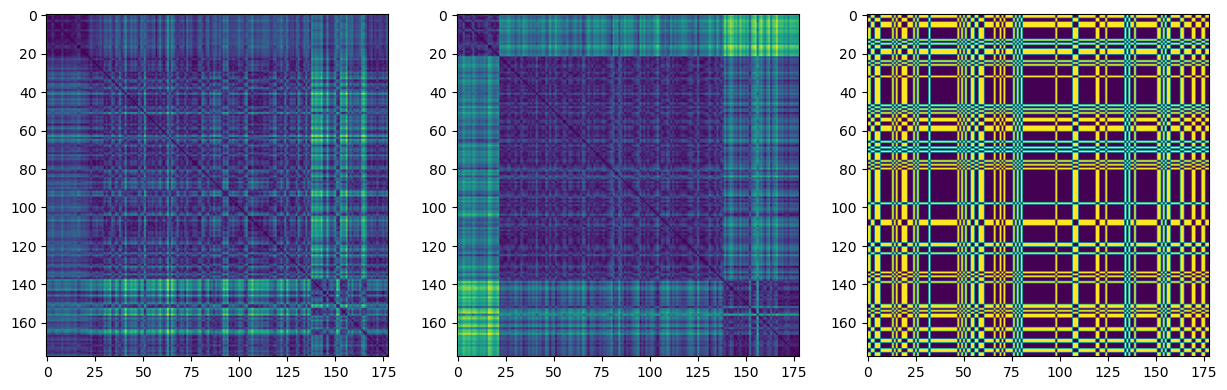

In [186]:
plt.figure(figsize = (15,5))
plt.subplot(1,3,1)
plt.imshow(s_patients_rdm_gender)
plt.subplot(1,3,2)
plt.imshow(z_patients_rdm_gender)
plt.subplot(1,3,3)
plt.imshow(gender_rdm)
plt.show()

## RSA: Gender

In [189]:
fit_rsa(s_patients_rdm_gender, gender_rdm)

-0.003795754212090757

In [190]:
fit_rsa(z_patients_rdm_gender, gender_rdm)

0.0663893931971944

## RDMS: Handedness

In [191]:
handed_vector = ADHDdf['Handedness'].values
handed_vector

array([ 1.00e+00,  1.00e+00,  1.00e+00,  1.00e+00,  1.00e+00,  1.00e+00,
        1.00e+00,  1.00e+00,  1.00e+00,  1.00e+00,  0.00e+00,  1.00e+00,
        1.00e+00,  1.00e+00,  1.00e+00,  1.00e+00,  1.00e+00,  0.00e+00,
        1.00e+00,  1.00e+00,  1.00e+00,  1.00e+00,  5.70e-01, -9.99e+02,
        5.00e-01,  7.30e-01,  2.60e-01,  6.70e-01,  9.10e-01,  6.20e-01,
        8.30e-01,  4.70e-01,  6.50e-01,  5.20e-01,  2.90e-01,  1.30e-01,
        3.10e-01,  2.70e-01,  9.10e-01,  5.80e-01,  1.10e-01,  8.60e-01,
        9.10e-01,  6.00e-01,  1.00e+00,  1.00e+00,  8.20e-01,  6.40e-01,
        6.80e-01,  4.50e-01,  1.00e+00,  6.80e-01,  8.30e-01,  9.50e-01,
        4.40e-01,  2.00e-01,  8.20e-01,  1.00e+00,  8.20e-01,  1.00e+00,
        3.90e-01,  1.60e-01,  2.40e-01,  1.00e+00,  8.60e-01,  8.20e-01,
        4.60e-01,  7.70e-01,  8.20e-01,  1.60e-01,  5.80e-01,  6.90e-01,
        9.10e-01,  1.00e+00,  1.00e+00,  7.40e-01,  5.20e-01,  6.80e-01,
        4.20e-01,  5.70e-01,  7.90e-01,  2.20e-01, 

In [192]:
handed_is_999 = handed_vector==-999

In [193]:
handed_is_nan = np.isnan(handed_vector)

In [194]:
handed_is_nan

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [195]:
handed_is_not_nan = ~handed_is_nan
handed_is_not_nan

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [196]:
handed_is_not_999 = ~handed_is_999
handed_is_not_999

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [197]:
handed_good_subjects = handed_is_not_999 * handed_is_not_nan
handed_good_subjects

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [198]:
handed_good_patients = handed_vector[handed_good_subjects]

In [199]:
s_patients = s_encoder.predict(data_patients)[0]
z_patients = z_encoder.predict(data_patients)[0]
handed = np.array(handed_good_patients)

In [200]:
z_good_patients_handed = z_patients[handed_good_subjects,:]

In [201]:
s_good_patients_handed = s_patients[handed_good_subjects,:]

In [202]:
s_patients_rdm_handed = make_RDM(s_good_patients_handed)
z_patients_rdm_handed = make_RDM(z_good_patients_handed)
handed_rdm = make_RDM(handed_good_patients)

In [203]:
s_patients_rdm_handed.shape

(178, 178)

In [204]:
z_patients_rdm_handed.shape

(178, 178)

In [205]:
handed_rdm.shape

(178, 178)

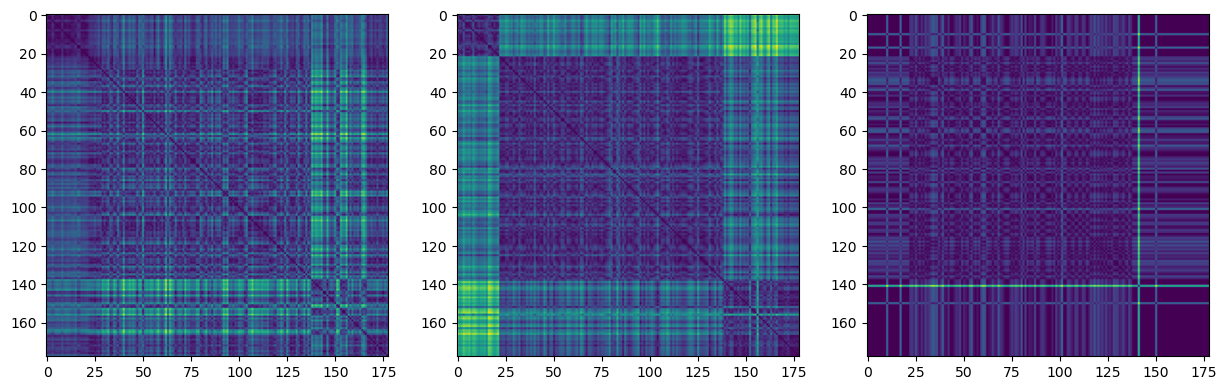

In [206]:
plt.figure(figsize = (15,5))
plt.subplot(1,3,1)
plt.imshow(s_patients_rdm_handed)
plt.subplot(1,3,2)
plt.imshow(z_patients_rdm_handed)
plt.subplot(1,3,3)
plt.imshow(handed_rdm)
plt.show()

## RSA: Gender

In [207]:
fit_rsa(s_patients_rdm_handed, handed_rdm)

0.07062918661829855

In [208]:
fit_rsa(z_patients_rdm_handed, handed_rdm)

0.03001752130193083

## RDMS: IQ

In [127]:
IQ_vector = ADHDdf['Full4 IQ'].values
IQ_vector

array([ 106.,   89.,   88.,   99.,   94.,  126.,  108.,  102.,  112.,
        113.,  119.,   86.,  103.,  134.,  126.,  121.,   94.,   89.,
        122.,  122.,   88.,   90.,  123.,  129.,  116.,  129.,  118.,
        107.,   99.,  125.,  108.,  125.,  119.,  107.,  125.,  115.,
        131.,  102.,  109.,   95.,   98.,  105.,  111.,  116.,   84.,
        107.,  114.,  109.,  134.,  124.,   97.,  107.,  132.,   99.,
        117.,  100.,  102.,  128.,  128.,  107.,   88.,  103.,  106.,
        102.,   95.,   95.,  108.,  119.,  109.,  115.,   94.,  109.,
        101.,  134.,   95.,  132.,   99.,  108.,  100.,   94.,   95.,
        105.,   92.,  103.,   89.,  109.,   91.,  108.,  108.,  109.,
        107., -999.,  118.,   99.,  122.,  101.,  122.,  101.,   94.,
        115.,  102.,  120.,  121.,   94.,   83.,   81.,  113.,   92.,
        115.,   75.,  106.,   93.,  129.,   99.,  114.,   84.,  131.,
         88.,   73.,  106., -999.,   78.,  102.,   95.,   99.,  127.,
         94.,  106.,

In [128]:
IQ_is_999 = IQ_vector==-999
IQ_is_999

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False,

In [129]:
IQ_is_nan = np.isnan(IQ_vector)

In [130]:
IQ_is_nan

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [131]:
IQ_is_not_nan = ~IQ_is_nan
IQ_is_not_nan

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [132]:
IQ_is_not_999 = ~IQ_is_999
IQ_is_not_999

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,

In [133]:
IQ_good_subjects = IQ_is_not_999 * IQ_is_not_nan
IQ_good_subjects

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,

In [134]:
IQ_good_patients = IQ_vector[IQ_good_subjects]

In [135]:
s_patients_IQ = s_encoder.predict(data_patients)[0]
z_patients_IQ = z_encoder.predict(data_patients)[0]
IQ = np.array(IQ_good_patients)

In [136]:
z_good_patients_IQ = z_patients_IQ[IQ_good_subjects,:]

In [137]:
s_good_patients_IQ = s_patients_IQ[IQ_good_subjects,:]

In [138]:
s_patients_rdm_IQ = make_RDM(s_good_patients_IQ)
z_patients_rdm_IQ = make_RDM(z_good_patients_IQ)
IQ_rdm = make_RDM(IQ)

In [139]:
IQ_rdm.shape

(161, 161)

In [140]:
z_patients_rdm_IQ.shape

(161, 161)

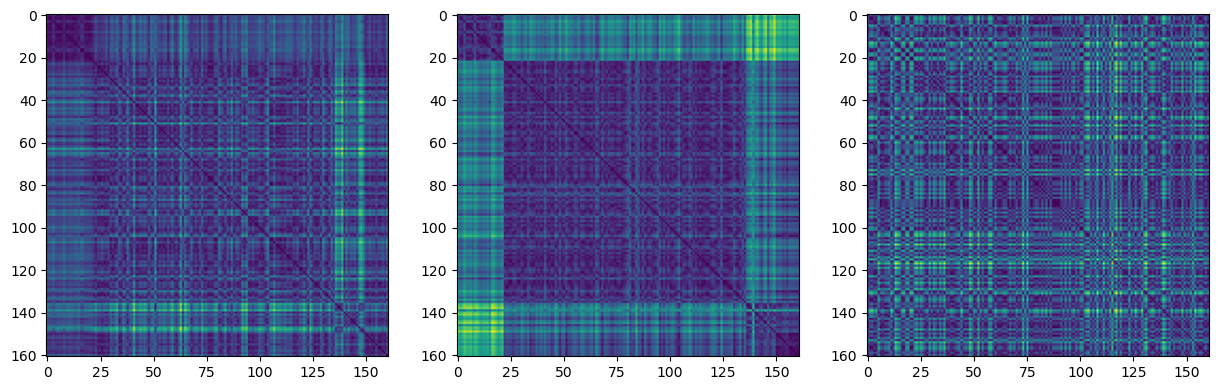

In [141]:
plt.figure(figsize = (15,5))
plt.subplot(1,3,1)
plt.imshow(s_patients_rdm_IQ)
plt.subplot(1,3,2)
plt.imshow(z_patients_rdm_IQ)
plt.subplot(1,3,3)
plt.imshow(IQ_rdm)
plt.show()

## RSA: IQ

In [142]:
fit_rsa(s_patients_rdm_IQ, IQ_rdm)

-0.022000856510691263

In [143]:
fit_rsa(z_patients_rdm_IQ, IQ_rdm)

-0.007970835261048874

## RDMS: Verbal IQ

In [144]:
verbal_vector = ADHDdf['Verbal IQ'].values
verbal_vector

array([ 122.,   89.,   93.,   93.,   93.,  138.,  106.,  108.,  116.,
        110.,  119.,  110.,   99.,  134.,  142.,  146.,   93.,   95.,
        106.,  112.,   81.,  100.,  115.,  131.,  109.,  109.,  122.,
        106.,  106.,  126.,  110.,  125.,  108.,   96.,  115.,  120.,
        141.,  101.,  109.,   98.,  108.,  114.,  115.,  107.,   88.,
        106.,  118.,   98.,  123.,  116.,   99.,  108.,  137.,  109.,
        123.,  104.,  107.,  135.,  123.,   98.,   99.,  106.,  106.,
        114.,   85.,   99.,  122.,  118.,  105.,  117.,  101.,  101.,
         97.,  136.,   95.,  130.,  106.,   98.,  102.,   89.,  105.,
        108.,   99.,  100.,   91.,  109.,  100.,  100.,   98.,  119.,
        109., -999.,  120.,   93.,  109.,   99.,  132.,   95.,  101.,
        122.,  104.,  116.,  113.,   96.,   77.,   81.,  119.,  107.,
        116.,   65.,  102.,   98.,  119.,  106.,  115.,   89.,  132.,
         92.,   77.,  106., -999.,   82.,  109.,   82.,  109.,  126.,
         98.,  115.,

In [145]:
verbal_is_999 = verbal_vector==-999
verbal_is_999

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False,

In [146]:
verbal_is_nan = np.isnan(verbal_vector)
verbal_is_nan

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [147]:
verbal_is_not_nan = ~verbal_is_nan
verbal_is_not_nan

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [148]:
verbal_is_not_999 = ~verbal_is_999
verbal_is_not_999

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,

In [149]:
verbal_good_subjects = verbal_is_not_999 * verbal_is_not_nan
verbal_good_subjects

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,

In [150]:
verbal_good_patients = verbal_vector[verbal_good_subjects]

In [151]:
s_patients_verbal = s_encoder.predict(data_patients)[0]
z_patients_verbal = z_encoder.predict(data_patients)[0]
verbal = np.array(verbal_good_patients)

In [152]:
z_good_patients_verbal = z_patients_verbal[verbal_good_subjects,:]

In [153]:
s_good_patients_verbal = s_patients_verbal[verbal_good_subjects,:]

In [154]:
s_patients_rdm_verbal = make_RDM(s_good_patients_verbal)
z_patients_rdm_verbal = make_RDM(z_good_patients_verbal)
verbal_rdm = make_RDM(verbal)

In [155]:
verbal_rdm.shape

(147, 147)

In [156]:
z_patients_rdm_verbal.shape

(147, 147)

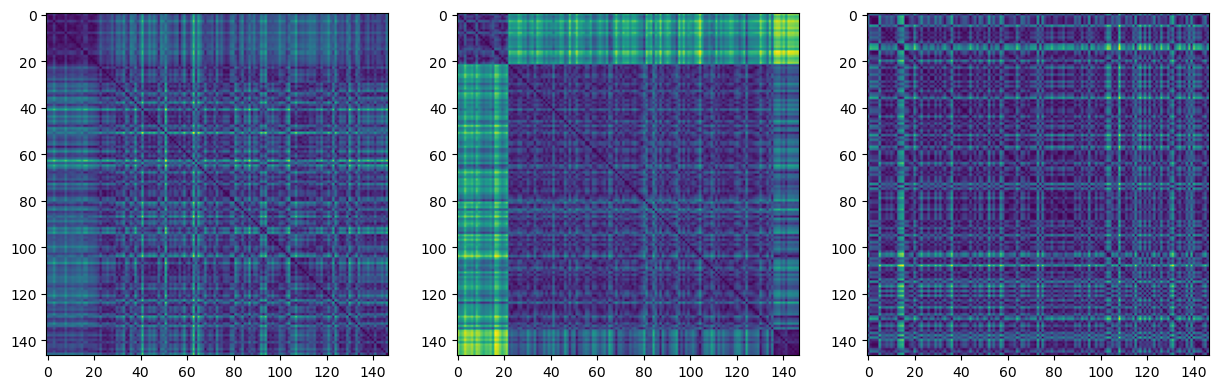

In [157]:
plt.figure(figsize = (15,5))
plt.subplot(1,3,1)
plt.imshow(s_patients_rdm_verbal)
plt.subplot(1,3,2)
plt.imshow(z_patients_rdm_verbal)
plt.subplot(1,3,3)
plt.imshow(verbal_rdm)
plt.show()

## RSA: Verbal IQ

In [158]:
fit_rsa(s_patients_rdm_verbal, verbal_rdm)

-0.0036149699852686522

In [159]:
fit_rsa(z_patients_rdm_verbal, verbal_rdm)

0.040222523271573864

## RDMS: Performance IQ

In [160]:
performance_vector = ADHDdf['Performance IQ'].values
performance_vector

array([ 108.,   88.,   98.,  108.,  100.,  108.,  106.,  106.,  123.,
        123.,  125.,   79.,  115.,  129.,  119.,  106.,  112.,  106.,
        135.,  125.,   98.,   90.,  125.,  121.,  120.,  134.,  109.,
        106.,   91.,  119.,  104.,  117.,  128.,  118.,  129.,  106.,
        114.,  103.,  106.,   93.,   88.,   94.,  104.,  123.,   82.,
        107.,  107.,  120.,  137.,  126.,   95.,  103.,  119.,   88.,
        107.,   97.,   97.,  116.,  126.,   94.,   82.,  100.,  104.,
         89.,  107.,   92.,   93.,  117.,  111.,  109.,   88.,  116.,
        106.,  124.,   96.,  127.,   91.,  118.,   97.,  100.,   86.,
        100.,   87.,  105.,   91.,  106.,   85.,  115.,  119.,   97.,
        102., -999.,  111.,  104.,  131.,  103.,  107.,  107.,   88.,
        105.,   99.,  119.,  125.,   93.,   93.,   84.,  104.,   79.,
        115.,   89.,  107.,   89.,  133.,   91.,  109.,   83.,  123.,
         88.,   72.,  104., -999.,   79.,   93.,  108.,   88.,  121.,
         90.,   96.,

In [161]:
performance_is_999 = performance_vector==-999
performance_is_999

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False,

In [162]:
performance_is_nan = np.isnan(performance_vector)
performance_is_nan

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [163]:
performance_is_not_nan = ~performance_is_nan
performance_is_not_nan

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [164]:
performance_is_not_999 = ~performance_is_999
performance_is_not_999

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,

In [165]:
performance_good_subjects = performance_is_not_999 * performance_is_not_nan
performance_good_subjects

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,

In [166]:
performance_good_patients = performance_vector[performance_good_subjects]

In [167]:
s_patients_performance = s_encoder.predict(data_patients)[0]
z_patients_performance = z_encoder.predict(data_patients)[0]
performance = np.array(performance_good_patients)

In [168]:
z_good_patients_performance = z_patients_performance[performance_good_subjects,:]

In [169]:
s_good_patients_performance = s_patients_performance[performance_good_subjects,:]

In [170]:
s_patients_rdm_performance = make_RDM(s_good_patients_performance)
z_patients_rdm_performance = make_RDM(z_good_patients_performance)
performance_rdm = make_RDM(performance)

In [171]:
performance_rdm.shape

(147, 147)

In [172]:
z_patients_rdm_performance.shape

(147, 147)

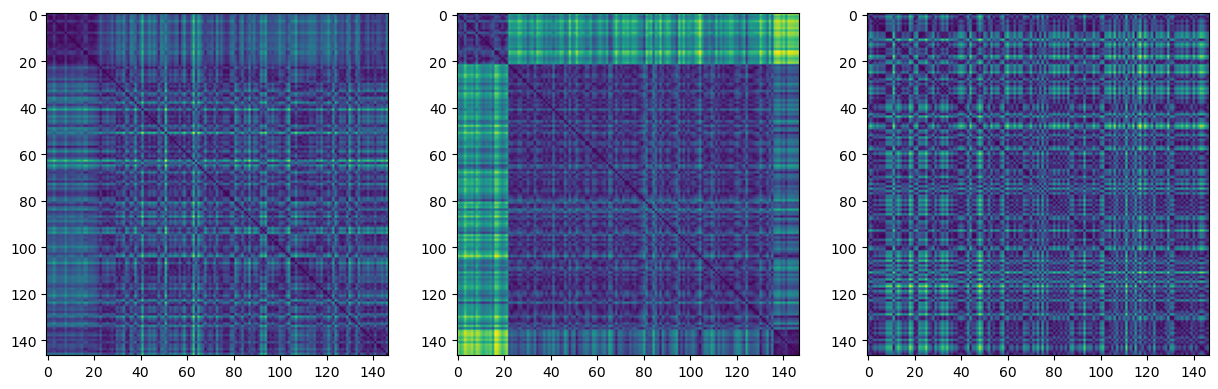

In [173]:
plt.figure(figsize = (15,5))
plt.subplot(1,3,1)
plt.imshow(s_patients_rdm_performance)
plt.subplot(1,3,2)
plt.imshow(z_patients_rdm_performance)
plt.subplot(1,3,3)
plt.imshow(performance_rdm)
plt.show()

## RSA: Performance IQ

In [174]:
fit_rsa(s_patients_rdm_performance, performance_rdm)

-0.04382412524068618

In [175]:
fit_rsa(z_patients_rdm_performance, performance_rdm)

-0.010965745760559547